In [83]:
import torch
import transformer_lens

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

model = transformer_lens.HookedTransformer.from_pretrained("ai-forever/mGPT", device=device)
print(model.cfg.device)


Loaded pretrained model ai-forever/mGPT into HookedTransformer
mps


In [84]:
print(model.cfg)

HookedTransformerConfig:
{'NTK_by_parts_factor': 8.0,
 'NTK_by_parts_high_freq_factor': 4.0,
 'NTK_by_parts_low_freq_factor': 1.0,
 'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': np.float64(11.313708498984761),
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 128,
 'd_mlp': 8192,
 'd_model': 2048,
 'd_vocab': 100000,
 'd_vocab_out': 100000,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='mps'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': np.float64(0.017677669529663688),
 'load_in_4bit': False,
 'model_name': 'mGPT',
 'n_ctx': 2048,
 'n_devices': 1,
 'n_heads': 16,
 'n_key_value_heads': None,
 'n_layers': 24,
 'n_params': 1207959552,
 'normalization_typ

In [85]:
from typing import List

from transformer_lens import ActivationCache


def collect_activation_cache(data: List[dict[str, str]]):
    activation_cache: dict[str, List[ActivationCache]] = {}
    for entry in data:
        for language, text in entry.items():
            if language not in activation_cache:
                activation_cache[language] = []

            with torch.no_grad():
                tokens = model.to_tokens(text)
                logits, cache = model.run_with_cache(tokens)
                activation_cache[language].append(cache)

    return activation_cache


In [97]:
import numpy as np


def collect_hidden_space_by_language(activation_cache: dict[str, List[ActivationCache]]):
    # { [lang]: np.array([d_model, n_prompts, n_layers]) }
    hidden_space_for_language = {}

    for language, language_caches in activation_cache.items():
        # d_model, n_prompts, n_layers
        current_hidden_space_for_language = np.zeros((model.cfg.d_model, len(language_caches), model.cfg.n_layers))

        for cache_i, cache in enumerate(language_caches):
            # layer, batch, pos, d_model
            accum_resid = cache.accumulated_resid(apply_ln=True)
            current_hidden_space_for_language[:, cache_i, :] = accum_resid[1:, 0, -1, :].cpu().numpy().T

        hidden_space_for_language[language] = current_hidden_space_for_language

    return hidden_space_for_language

In [111]:
from sklearn.decomposition import PCA


def extract_pca_components(hidden_space_by_language, n_components=10):
    """
    Extract common subspace across languages using PCA.
    This identifies directions that explain most variance in both languages.
    """
    languages = list(hidden_space_by_language.keys())

    n_layers = hidden_space_by_language[languages[0]].shape[2]
    d_model = hidden_space_by_language[languages[0]].shape[0]
    n_prompts = hidden_space_by_language[languages[0]].shape[1]

    pca_components = []
    explained_variance_ratios = []

    for layer in range(n_layers):
        # Concatenate embeddings from both languages
        combined_embeddings = np.zeros((d_model, n_prompts * len(languages)))

        for i, lang in enumerate(languages):
            combined_embeddings[:, i * n_prompts : (i + 1) * n_prompts] = hidden_space_by_language[lang][:, :, layer]

        # Apply PCA to find common directions
        pca = PCA(n_components=n_components)
        # Transpose to get [n_samples, n_features] format expected by sklearn
        pca.fit_transform(combined_embeddings.T)

        pca_components.append(pca.components_)  # Principal components [n_components, d_model]
        explained_variance_ratios.append(pca.explained_variance_ratio_)

    return pca_components, explained_variance_ratios


def project_onto_pca(hidden_space_by_language, pca_components):
    """
    Project each language's embeddings onto the common subspace.
    """
    n_layers = len(pca_components)
    projections = {}

    for lang in hidden_space_by_language:
        projections[lang] = []

        for layer in range(n_layers):
            # Get embeddings for this layer and language
            layer_embeddings = hidden_space_by_language[lang][:, :, layer]  # [d_model, n_prompts]
            projection = pca_components[layer] @ layer_embeddings
            projections[lang].append(projection)

    return projections

In [128]:
import matplotlib.pyplot as plt


def visualize_explained_variance(pca_components, explained_variance_ratios):
    plt.figure(figsize=(12, 6))

    for layer in [0, len(pca_components) // 2 - 1, len(pca_components) - 1]:  # Plot only a few layers for clarity
        plt.plot(
            np.arange(1, len(explained_variance_ratios[layer]) + 1),
            explained_variance_ratios[layer],
            marker="o",
            label=f"Layer {layer}",
        )

    plt.xlabel("Number of Components")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Explained Variance (PCA)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

In [129]:
def visualize_projections(hidden_space_by_language, projections):
    languages = list(hidden_space_by_language.keys())

    n_layers = len(projections[languages[0]])

    for layer in [0, n_layers // 2 - 1, n_layers - 1]:  # Plot only a few layers for clarity
        plt.figure(figsize=(12, 6))

        for lang in languages:
            # Get projections for this language and layer
            proj = projections[lang][layer]

            # Plot the first two components
            plt.subplot(1, 2, 1)
            plt.scatter(proj[0], proj[1], label=f"{lang} (sim)", alpha=0.7, s=100)
            plt.xlabel("Component 1")
            plt.ylabel("Component 2")
            plt.title(f"Words Projected onto main PCA components (Layer {layer})")
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.subplot(1, 2, 2)
            plt.scatter(proj[-1], proj[-2], label=f"{lang} (diff)", alpha=0.7, s=100)
            plt.xlabel("Component n")
            plt.ylabel("Component n-1")
            plt.title(f"Words Projected onto last PCA components (Layer {layer})")
            plt.legend()
            plt.grid(True, alpha=0.3)

        plt.show()

In [130]:
def find_lexical_subspace_intersection(data):
    print("Data len: ", len(data))

    activation_cache = collect_activation_cache(data)
    # { [lang]: np.array([d_model, n_prompts, n_layers]) }
    hidden_space_by_language = collect_hidden_space_by_language(activation_cache)

    print("Language hidden space shape: ", hidden_space_by_language["EN"].shape)

    pca_components, explained_variance_ratios = extract_pca_components(hidden_space_by_language)
    projections = project_onto_pca(hidden_space_by_language, pca_components)

    visualize_explained_variance(pca_components, explained_variance_ratios)
    visualize_projections(hidden_space_by_language, projections)


Data len:  11
Language hidden space shape:  (2048, 11, 24)


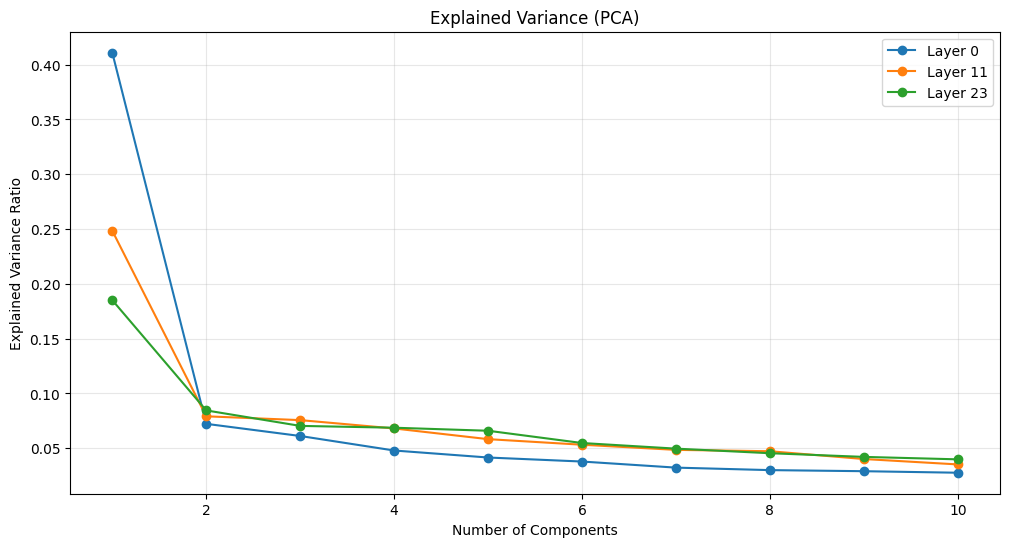

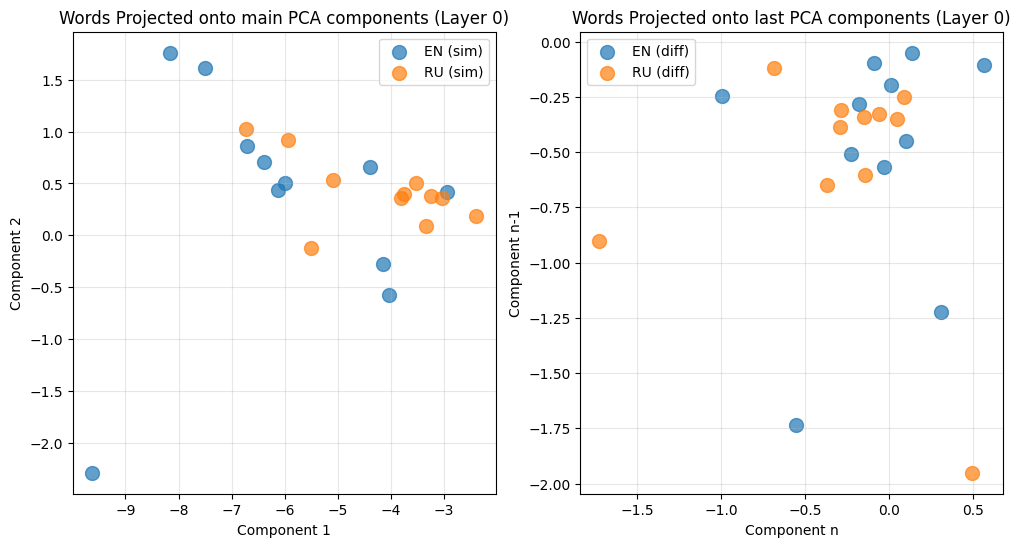

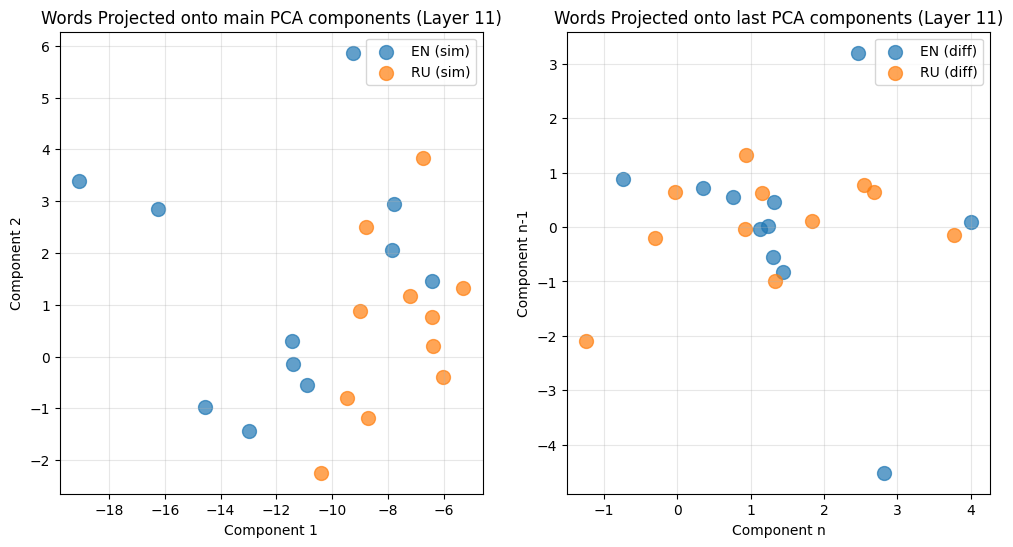

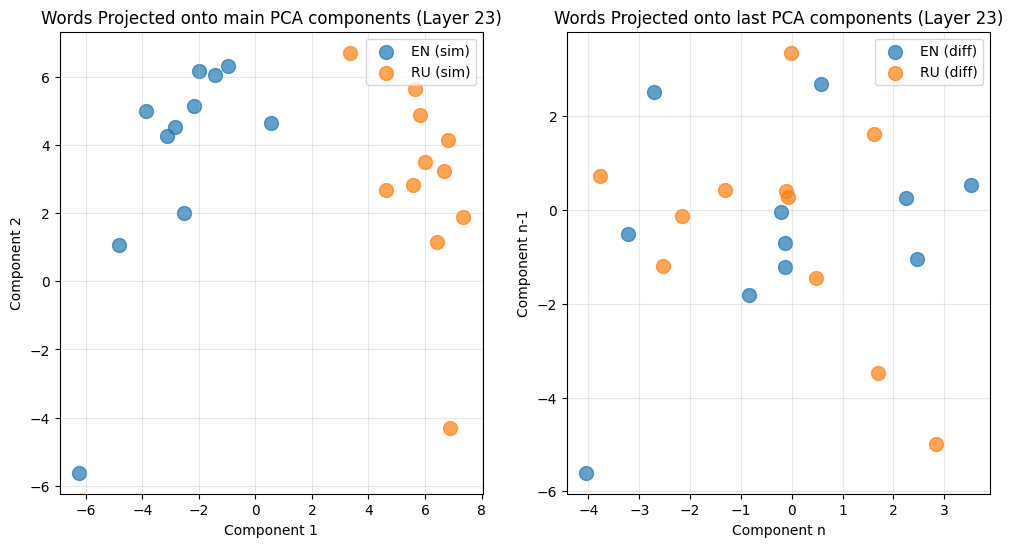

In [131]:
toy_data = [
    {"EN": "Hello", "RU": "Здравствуй"},
    {"EN": "darkness", "RU": "тьма"},
    {"EN": "my", "RU": "мой"},
    {"EN": "old", "RU": "старый"},
    {"EN": "friend", "RU": "друг"},
    {"EN": "I've", "RU": "Я"},
    {"EN": "come", "RU": "пришел"},
    {"EN": "to talk", "RU": "поговорить"},
    {"EN": "with", "RU": "с"},
    {"EN": "you", "RU": "тобой"},
    {"EN": "again", "RU": "снова"},
]

find_lexical_subspace_intersection(toy_data)